# EDA: Análisis exploratorio de datos y transformaciones
***

#### 1. Importación de Librerias necesarias

In [141]:
import numpy as np
import pandas as pd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj
import folium
from folium import plugins
import seaborn as sns
from datetime import datetime  # Importa datetime
pd.set_option('max_columns', None)

In [142]:
mi_paleta_personalizada = ["#FF5733", "#3498DB", "#FFC300", "#16A085", "#C0392B"]
sns.set_palette(mi_paleta_personalizada)

## 2. Datos
1) Archivo excel ***'homicidios.xlsx'*** : 

 >Página hechos: Contiene informacción de siniestros viales con victimas fatales por fecha identificados con una clave ID.<br>
  Página victimas: Contiene información de las caracteristicas de las victimas fatales de los siniestros viales de la tabla anterior, relacionadas con el campo ID_hecho.<br>

2) Archivo csv ***'conteo_vehicular_coor.csv'***: 

>Es una dataset que contiene información de conteo de vehículos por tipo en cruces de avenidas de CABA. A este dataset se le agrego las coordenas de latitud y longitud del cruce utilizando GoogleMaps.

3) Archivo csv ***'barrios.csv'***:

>Es un dataset con información y límites Geograficos de los barrio CABA.

### 2.1 Ingesta de datos

El archivo homicidios posee la información central de análisis.

#### Importar los datos de la pagina excel 'hechos' en dataframe df_hechos:

In [143]:
df_hechos= pd.read_excel('homicidios.xlsx', engine='openpyxl')

In [144]:
df_hechos.head(2)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS


Analizo si se tienen registros duplicados: no presenta registros duplicados.

In [145]:
data_duplicates_df_hechos=  df_hechos.duplicated( subset=['ID'],keep="first")
data_duplicates_df_hechos.sum()

0

#### Importar los datos de la pagina excel 'victimas' en dataframe df_victimas:

In [146]:
df_victimas = pd.read_excel('homicidios.xlsx', sheet_name='VICTIMAS', engine='openpyxl')

In [147]:
df_victimas.head(3)

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00


Analizó si se tienen registros duplicados: Ni presenta registros duplicados.

In [148]:
data_duplicates_df_victimas=  df_victimas.duplicated()
data_duplicates_df_victimas.sum()

0

## 3. Transformaciones y Análisis exploratorio de datos

### 3.1 Analisis exploratorio de df_hechos
***

#### 1. Normalizo los nombres de columnas a mayúsculas y cambio el de nombre de columnas que tiene espacios en blanco. 

In [149]:
df_hechos.columns = df_hechos.columns.str.upper()

In [150]:
df_hechos.rename(columns={'POS X':'POS_X','POS Y':'POS_Y'}, inplace=True)

#### 2. Analizo información de cantidad y tipo de datos por columna.

Utilizo función info() para analizar dataset:

In [151]:
df_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  CALLE                  695 non-null    object        
 11  ALTURA                 129 non-null    float64       
 12  CRUCE                  525 non-null    object        
 13  DIREC

**Observaciones:**
* ALTURA presenta valores nulos.<br>
* CRUCE presenta valores  nulos.<br>
* HORA y HH tienen la misma información.
* DIRECCIÓN NORMALIZADA presenta valores nulos<br>
* FECHA no esta en formato Datetime.<br>
* POX_ , POSy no esta en formato float.<br>


#### 3. Elimino columnas ALTURA, CRUCE, HORA. También elimino DIRECCIÓN NORMALIZADA ya que trabajaré con los datos de latitud y longitd y no aporta valor al análisis.

In [152]:
df_hechos.drop(columns=['ALTURA','CRUCE','DIRECCIÓN NORMALIZADA', 'HORA'], inplace=True)

#### 4. Convierto fecha a formato date_time

In [153]:
df_hechos['FECHA']=pd.to_datetime(df_hechos['FECHA'],errors='çoerce')

Peridodo de tiempo contentino en el df_hechos, inicio 2016 a  2021 incluido.

In [154]:
df_hechos['FECHA'].min()

Timestamp('2016-01-01 00:00:00')

In [155]:
df_hechos['FECHA'].max()

Timestamp('2021-12-30 00:00:00')

#### 5.Convierto  POS_X y POS_Y a formato float

In [156]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return None

df_hechos['POS_X'] = df_hechos['POS_X'].apply(convert_to_float)
df_hechos['POS_Y'] = df_hechos['POS_Y'].apply(convert_to_float)

In [157]:
df_hechos['POS_Y'].isnull().sum()

12

Se encuentran 12 valore con error en las coordenadas y que se pasaron a nulo al hacer la conversión a float.

In [158]:
df_hechos[df_hechos['POS_Y'].isnull()]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,CALLE,COMUNA,XY (CABA),POS_X,POS_Y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,2016,4,20,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,"LUGONES, LEOPOLDO AV.",13,Point (. .),NaN,NaN,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,AUTOPISTA BUENOS AIRES - LA PLATA,4,Point (. .),NaN,NaN,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20,SD,CALLE,NaN,0,Point (. .),NaN,NaN,PEATON-SD,PEATON,SD
139,2016-0174,1,2016-12-27,2016,12,27,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,AUTOPISTA 25 DE MAYO,0,Point (. .),NaN,NaN,SD-SD,SD,SD
176,2017-0042,1,2017-04-10,2017,4,10,9,AV. LEOPOLDO LUGONES PKM 6900,GRAL PAZ,"LUGONES, LEOPOLDO AV.",14,Point (. .),NaN,NaN,MOTO-CARGAS,MOTO,CARGAS
180,2017-0050,2,2017-04-28,2017,4,28,11,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,AUTOPISTA PERITO MORENO,9,Point (. .),NaN,NaN,MOTO-CARGAS,MOTO,CARGAS
181,2017-0051,1,2017-05-01,2017,5,1,3,AU DELLEPIANE 2400,AUTOPISTA,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.,7,Point (. .),NaN,NaN,AUTO-AUTO,AUTO,AUTO
256,2017-0140,1,2017-11-19,2017,11,19,23,AU ARTURO FRONDIZI PKM 3100,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,Point (. .),NaN,NaN,MOTO-PASAJEROS,MOTO,PASAJEROS
313,2018-0039,1,2018-04-21,2018,4,21,22,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,"LUGONES, LEOPOLDO AV.",14,Point (. .),NaN,NaN,PEATON-AUTO,PEATON,AUTO
546,2020-0026,1,2020-05-17,2020,5,17,6,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,"LUGONES, LEOPOLDO AV.",14,Point (. .),NaN,NaN,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO


#### 6. Incorporo una columna con el tipo de dia

In [159]:
df_hechos['DIA_SEMANA'] = df_hechos['FECHA'].dt.strftime('%A')
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
df_hechos['DIA_SEMANA'] =df_hechos['DIA_SEMANA'].replace(dic)

#### 7. Analizó columnas con datos con etiqueta SD (sin dato)

- Visualizacion de registros que tienen SD en variable HORA y la reemplazo por 0 para poder covertir la variable a int

In [160]:
df_hechos[df_hechos['HH']=='SD']

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,CALLE,COMUNA,XY (CABA),POS_X,POS_Y,PARTICIPANTES,VICTIMA,ACUSADO,DIA_SEMANA
518,2019-0103,1,2019-12-18,2019,12,18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",11,Point (94643.11254058 103831.57115061),-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,Miercoles


In [161]:
df_hechos['HH'] = df_hechos['HH'].replace('SD', 0)

In [162]:
df_hechos['HH'] = df_hechos['HH'].astype(int)

- Analisis de Valores SD en columna VICTIMA y ACUSADO

In [163]:
df_hechos.VICTIMA.value_counts()

MOTO           295
PEATON         264
AUTO            83
BICICLETA       29
SD               9
CARGAS           7
PASAJEROS        5
MOVIL            2
OBJETO FIJO      1
PEATON_MOTO      1
Name: VICTIMA, dtype: int64

In [164]:
df_hechos.ACUSADO.value_counts()

AUTO           204
PASAJEROS      173
CARGAS         146
OBJETO FIJO     62
MOTO            57
SD              23
MULTIPLE        17
BICICLETA        7
OTRO             6
TREN             1
Name: ACUSADO, dtype: int64

La columna VICTIMA posee 9 valores SD.<br>
La columna ACUSADO posee 23 valores SD.<br>
Analizo si los valores SD de acusados y victimas puedo imputarlos con la columna participantes, pero no es posible ya que tambien son SD en dicha columna.<br>
Decido no realizar imputación de valores SD y dejarlo como una categoria en estas columnas.

In [165]:
df_hechos[df_hechos['VICTIMA']=='SD']

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,CALLE,COMUNA,XY (CABA),POS_X,POS_Y,PARTICIPANTES,VICTIMA,ACUSADO,DIA_SEMANA
35,2016-0049,1,2016-04-17,2016,4,17,0,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI KM....,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4,Point (. .),-58.377146,-34.636575,SD-SD,SD,SD,Domingo
76,2016-0101,1,2016-08-07,2016,8,7,19,AV GRAL PAZ Y JORGE CHAVEZ,GRAL PAZ,"PAZ, GRAL. AV.",9,Point (93946.81673714 97681.68907836),-58.529329,-34.650150,SD-SD,SD,SD,Domingo
88,2016-0115,1,2016-09-02,2016,9,2,11,ARIAS Y TRONADOR,CALLE,ARIAS,12,Point (97608.87024259 108884.67029908),-58.489350,-34.549177,SD-CARGAS,SD,CARGAS,Viernes
92,2016-0119,1,2016-09-04,2016,9,4,6,CRISOLOGO LARRALDE Y AVDA TRIUNVIRATO,AVENIDA,"LARRALDE, CRISOLOGO AV.",12,Point (96944.69676081 107291.52292157),-58.496592,-34.563536,SD-SD,SD,SD,Domingo
139,2016-0174,1,2016-12-27,2016,12,27,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,AUTOPISTA 25 DE MAYO,0,Point (. .),NaN,NaN,SD-SD,SD,SD,Martes
164,2017-0029,1,2017-03-07,2017,3,7,2,MOZART Y TANDIL,CALLE,MOZART,9,Point (98009.35575364 97985.81952007),-58.485013,-34.647425,SD-AUTO,SD,AUTO,Martes
201,2017-0074,1,2017-06-04,2017,6,4,12,CASCO 133,CALLE,CASCO,9,Point (94281.31244858 99043.29027489),-58.525671,-34.637878,SD-SD,SD,SD,Domingo
214,2017-0089,1,2017-07-13,2017,7,13,12,MARTINIANO LEGUIZAMON 901,CALLE,"LEGUIZAMON, MARTINIANO",9,Point (95246.78684010 97935.32361317),-58.515147,-34.647871,SD-AUTO,SD,AUTO,Jueves
269,2017-0155,1,2017-12-12,2017,12,12,21,AV. RIVADAVIA 6350,AVENIDA,RIVADAVIA AV.,7,Point (100674.98109200 100299.64949548),-58.455939,-34.626569,SD-MOTO,SD,MOTO,Martes


#### 8. Agrego columna con Barrio utilizando un dataset con Barrio para cada accidente.

Para poder asignarle el barrio a la ubicacion del accidente se trabajó con la librería Geopandas.
Las columnas lat y lon identifican la latitud y la longitud de la posición geoespacial de los accidentes. Sin embargo, necesitamos que la posición se exprese mediante la forma geométrica Punto, para poder trabajarlo desde GeoPandas. Es decir que dedí transformar el DataFrame en un GeoDataFrame. Lo llamé geo_hechos.
Para generar un GeoDataFrame, agregué a las columnas del DataFrame una nueva columna que contenía una forma geométrica. Es este caso, un punto, el cual se generó a partir de la latitud y la longitud.
Utilicé  el método gpd.points_from_xy.

In [166]:
geo_hechos = gpd.GeoDataFrame(df_hechos, geometry = gpd.points_from_xy(df_hechos['POS_X'], df_hechos['POS_Y']))
geo_hechos.head(2)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,CALLE,COMUNA,XY (CABA),POS_X,POS_Y,PARTICIPANTES,VICTIMA,ACUSADO,DIA_SEMANA,geometry
0,2016-0001,1,2016-01-01,2016,1,1,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,8,Point (98896.78238426 93532.43437792),-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,Viernes,POINT (-58.47534 -34.68757)
1,2016-0002,1,2016-01-02,2016,1,2,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",9,Point (95832.05571093 95505.41641999),-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,Sabado,POINT (-58.50878 -34.66978)


Para ubicar eestos puntos en los barrios de Buenos Aires segui los siguientes pasos:<br>
1- Leí los  datos del archivo barrios.csv en un DataFrame de pandas con el método read_csv. 

In [167]:
barrios = pd.read_csv("barrios.csv", encoding='latin1')
barrios.head()

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


2. Generé un GeoDataFrame de los barrios a partir del Dataframe. En este caso, la columna WKT ya contiene una forma geométrica **polígono** que representa el contorno de cada barrio. Pero en un formato WKT, que no permite generar un GeoDataFrame. Por lo tanto, lo tenemos que convertir a un formato *geometry*.

In [168]:
import shapely.wkt
barrios["WKT"] = barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(barrios, geometry='WKT')

3. Finalmente creo una funcion para obtener el nombre del barrio para cada siniestro

In [169]:
# Crear una función para obtener el nombre del barrio o manejar el caso cuando no se encuentra
def obtener_barrio(x):
    try:
        return geo_barrios[geo_barrios.contains(x)]['BARRIO'].iloc[0]
    except IndexError:
        return 'No encontrado'  # O un valor adecuado para los casos en los que no se encuentra

# Aplicar la función para obtener el nombre del barrio
geo_hechos['Barrio'] = geo_hechos.geometry.apply(obtener_barrio)

# Ahora, geo_hechos contendrá una nueva columna llamada 'Barrio' que indica el nombre del barrio correspondiente

In [170]:
geo_hechos.Barrio.value_counts()

FLORES               47
No encontrado        43
PALERMO              32
BALVANERA            30
BARRACAS             28
NUEVA POMPEYA        28
CONSTITUCION         27
RECOLETA             25
VILLA SOLDATI        25
LINIERS              23
BELGRANO             22
CABALLITO            21
PARQUE AVELLANEDA    21
VILLA LUGANO         21
MATADEROS            20
MONSERRAT            18
SAN NICOLAS          18
SAN CRISTOBAL        15
RETIRO               14
VILLA CRESPO         13
VILLA DEVOTO         13
SAAVEDRA             12
CHACARITA            12
PARQUE CHACABUCO     12
VILLA RIACHUELO      11
ALMAGRO              11
VILLA URQUIZA        11
BOEDO                11
PARQUE PATRICIOS      9
SAN TELMO             8
VELEZ SARSFIELD       8
BOCA                  8
NUÑEZ                 7
VILLA GRAL. MITRE     7
VILLA PUEYRREDON      6
FLORESTA              6
VILLA SANTA RITA      6
PATERNAL              6
PUERTO MADERO         5
VILLA LURO            5
AGRONOMIA             5
PARQUE CHAS     

Observo que hay muchos valores en la categoria No encontrado, me fijo cuales son y veo que son todos acciedentes que ocurrieron un poco fuera del limite de CABA pero fueron considerados en la ciduad. Por lo tanto los incorporo al barrio mas cercano.

In [171]:
no_encontrados = geo_hechos[geo_hechos['Barrio']=='No encontrado']

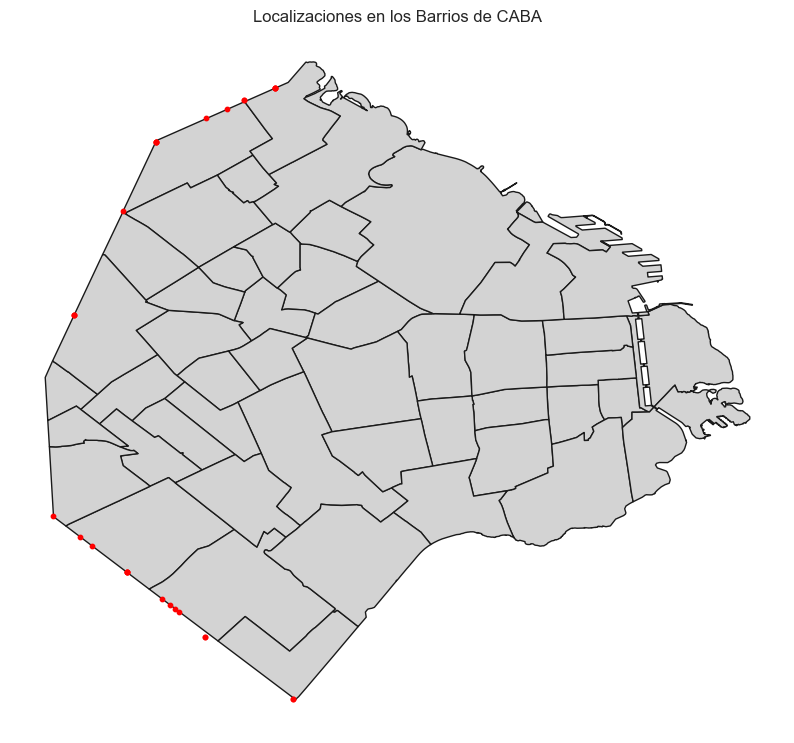

In [172]:
# Graficar los polígonos de los barrios
ax = geo_barrios.plot(figsize=(10, 10), color='lightgray', edgecolor='k')

# Graficar las localizaciones sobre los barrios
no_encontrados.plot(ax=ax, marker='o', color='red', markersize=10)

# Configurar el título y mostrar el gráfico
plt.title('Localizaciones en los Barrios de CABA')
plt.axis('off')  # Desactivar los ejes

# Mostrar el gráfico
plt.show()

Genero una funcion para agregar los puntos que estan cerca, pero fuera de los barrios de CABA y fueron tenidos en cuenta en el análisis

In [173]:
def obtener_barrio(x, barrios_df):
    closest_barrio = None
    min_distance = float('inf')
    
    for index, row in barrios_df.iterrows():
        distance = x.distance(row['WKT'])
        if distance < min_distance:
            min_distance = distance
            closest_barrio = row['BARRIO']
    
    if min_distance > 0.001:  # Ajusta el valor límite de distancia según tu necesidad
        return 'No encontrado'
    
    return closest_barrio

# Aplicar la función para obtener el nombre del barrio
geo_hechos['Barrio_2'] = geo_hechos.geometry.apply(lambda x: obtener_barrio(x, geo_barrios))

# Ahora, geo_hechos contendrá una nueva columna llamada 'Barrio' que indica el nombre del barrio correspondiente o 'No encontrado' si está fuera de los barrios cercanos.


In [174]:
geo_hechos['Barrio_2'].value_counts()

FLORES               47
PALERMO              32
BALVANERA            30
NUEVA POMPEYA        28
BARRACAS             28
CONSTITUCION         27
MATADEROS            26
RECOLETA             25
VILLA LUGANO         25
VILLA SOLDATI        25
LINIERS              24
BELGRANO             22
SAAVEDRA             21
CABALLITO            21
PARQUE AVELLANEDA    21
SAN NICOLAS          18
MONSERRAT            18
VILLA DEVOTO         16
SAN CRISTOBAL        15
RETIRO               14
No encontrado        14
VILLA CRESPO         13
VILLA RIACHUELO      13
CHACARITA            12
PARQUE CHACABUCO     12
BOEDO                11
ALMAGRO              11
NUÑEZ                11
VILLA URQUIZA        11
PARQUE PATRICIOS      9
SAN TELMO             8
VELEZ SARSFIELD       8
BOCA                  8
VILLA GRAL. MITRE     7
VILLA PUEYRREDON      6
FLORESTA              6
VILLA SANTA RITA      6
PATERNAL              6
PUERTO MADERO         5
AGRONOMIA             5
VILLA LURO            5
PARQUE CHAS     

### 3.1 Analisis exploratorio de df_victimas

In [175]:
df_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


#### 1. Analizó de valores SD en variables relevantes

In [43]:
SDV= (df_victimas.VICTIMA [df_victimas['VICTIMA']=='SD'].count()/df_victimas.shape[0])*100
SDS= (df_victimas.VICTIMA [df_victimas['SEXO']=='SD'].count()/df_victimas.shape[0])*100
SDR= (df_victimas.VICTIMA [df_victimas['ROL']=='SD'].count()/df_victimas.shape[0])*100
SDE= (df_victimas.VICTIMA [df_victimas['EDAD']=='SD'].count()/df_victimas.shape[0])*100
SDFF= (df_victimas.VICTIMA [df_victimas['FECHA_FALLECIMIENTO']=='SD'].count()/df_victimas.shape[0])*100

print('porcentaje de SD en VICTIMA =',SDV)
print('porcentaje de SD en SEXO =',SDS)
print('porcentaje de SD en ROL =',SDR)
print('porcentaje de SD en FECHA_FALLECIMIENTO =',SDFF)
print('porcentaje de SD en EDAD =',SDE)

porcentaje de SD en VICTIMA = 1.2552301255230125
porcentaje de SD en SEXO = 0.8368200836820083
porcentaje de SD en ROL = 1.5341701534170153
porcentaje de SD en FECHA_FALLECIMIENTO = 9.483960948396094
porcentaje de SD en EDAD = 7.391910739191074


Los valores SD que aparecen en edad los convierto a np.nan para que me deje cambiar el formato a numérico.

In [44]:
df_victimas['EDAD']=df_victimas['EDAD'].replace('SD',np.nan)

In [45]:
df_victimas['EDAD']=df_victimas['EDAD'].astype(float)

### 3.3 Transformaciones y Analisis de datos archivo 'conteo_vehicular_coor.csv'

In [192]:
df_conteo=pd.read_csv('conteo-vehicular_coor.csv', sep = ';')

#### 1. Analizo con info() columnas, cantidad de datos y tipo de dato:

In [193]:
df_conteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fecha        249 non-null    object
 1   hora_inicio  249 non-null    int64 
 2   hora_final   249 non-null    int64 
 3   livianos     249 non-null    int64 
 4   colectivos   249 non-null    int64 
 5   pesados      249 non-null    int64 
 6   LAT          249 non-null    object
 7   LONG         249 non-null    object
dtypes: int64(5), object(3)
memory usage: 15.7+ KB


In [196]:
df_conteo['LONG'].head(3)

0   -58.469636
1   -58.469636
2   -58.426016
Name: LONG, dtype: float64

#### 1. Convierto LAT y LONG a formato FLOAT

In [195]:
df_conteo['LONG'] = df_conteo['LONG'].str.replace(',', '.').astype(float)
df_conteo['LAT'] = df_conteo['LAT'].str.replace(',', '.').astype(float)
df_conteo['LONG']=df_conteo['LONG'].astype(float)
df_conteo['LAT']=df_conteo['LAT'].astype(float)

#### 2. Asigno un Barrio a cada punto de medición de conteo

Para asignar el barrio a cada cruce de conteo de vehículos, utilizo el mismo procecdimiento descripto en el df_hechos donde se le asignó a las coordenadas de cada accidente un Barrio. 

In [197]:
# genero geo_dataframe
geo_conteo = gpd.GeoDataFrame(df_conteo, geometry = gpd.points_from_xy(df_conteo['LONG'], df_conteo['LAT']))
geo_conteo.head(2)

# Aplicar la función obtener_barrio generada anteriormente para obtener el nombre del barrio
geo_conteo['BARRIO_C'] = geo_conteo.geometry.apply(lambda x: obtener_barrio(x, geo_barrios))


In [198]:
geo_conteo[geo_conteo['BARRIO_C']=='No encontrado']

,fecha,hora_inicio,hora_final,livianos,colectivos,pesados,LAT,LONG,geometry,BARRIO_C
179,2018-03-15,17,18,4802,188,62,-34.698703,-58.391436,POINT (-58.39144 -34.69870),No encontrado
180,2018-03-15,18,19,4468,213,62,-34.698703,-58.391436,POINT (-58.39144 -34.69870),No encontrado


In [199]:
geo_conteo=geo_conteo[geo_conteo['BARRIO_C']!='No encontrado']

Cambio la configuración del dataframe para que sea mas fácil trabajarlo en PowerBI

In [ ]:
df_conteo_melt= geo_conteo.melt(id_vars=['fecha', 'LAT', 'LONG', 'BARRIO_C','hora_inicio','hora_final'], 
                      value_vars=['livianos', 'colectivos', 'pesados'], 
                      var_name='tipo de vehiculo', 
                      value_name='cantidad')

df_conteo_melt.head(5)

Guardo el archivo en un csv para luego llevarlo a poweBI

In [201]:
df_conteo_melt.to_csv('df_geoconteo_melt.csv')

## 4. Análisis de variables numéricas

### 4.1 df_hechos

In [46]:
variables_numericas=df_hechos[['N_VICTIMAS','AAAA','MM','DD','HH','POS_X','POS_Y']]

In [47]:
df_hechos.describe()

,N_VICTIMAS,AAAA,MM,DD,HH,COMUNA,POS_X,POS_Y
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,684.000000,684.000000
mean,1.030172,2018.188218,6.692529,15.936782,11.640805,7.425287,-58.441545,-34.619632
std,0.179393,1.683754,3.571309,8.639646,6.709834,4.387050,0.046144,0.035289
min,1.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,-58.529942,-34.705250
25%,1.000000,2017.000000,4.000000,9.000000,6.000000,4.000000,-58.476218,-34.643689
50%,1.000000,2018.000000,7.000000,16.000000,11.000000,8.000000,-58.444513,-34.622928
75%,1.000000,2020.000000,10.000000,23.000000,17.250000,11.000000,-58.401841,-34.596799
max,3.000000,2021.000000,12.000000,31.000000,23.000000,15.000000,-58.356082,-34.534654


**Observaciones**<br>
    * No hay valores outlier en el número de victimas. <br>
    * Los valores máximos y minimos de las fechas y hora son correctos. <br>
    * Los valores máximo y mínimo de comuna son correctos.<br>

In [48]:
corr_variables_numericas = variables_numericas.corr()

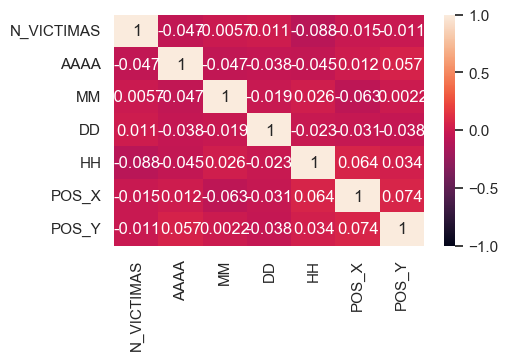

In [49]:
plt.figure(figsize=(5, 3))
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_variables_numericas,annot=True, vmax=1,vmin=-1)

No se obervan correlaciones entres las variables numéricas

### 4.2 df_victimas

In [50]:
df_victimas.describe()

,AAAA,MM,DD,EDAD
count,717.000000,717.000000,717.000000,664.000000
mean,2018.174338,6.688982,15.960948,42.167169
std,1.672655,3.575140,8.683358,19.788034
min,2016.000000,1.000000,1.000000,1.000000
25%,2017.000000,4.000000,9.000000,27.000000
50%,2018.000000,7.000000,16.000000,37.000000
75%,2019.000000,10.000000,23.000000,56.250000
max,2021.000000,12.000000,31.000000,95.000000


**Observaciones**<br>
    * No hay valores outliers. <br>
    * Los valores máximos y minimos de las fechas y hora son correctos. <br>
    * Los valores máximo y mínimo de edad estan en un rango razonable.<br>

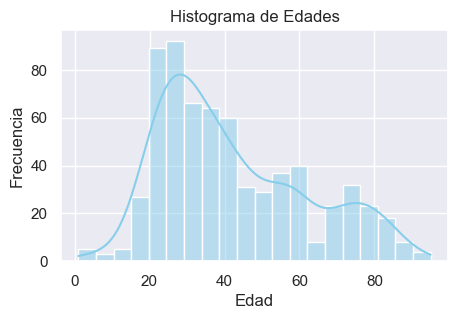

In [51]:
plt.figure(figsize=(5, 3))
# Crea el histograma
sns.histplot(data=df_victimas, x="EDAD", bins=20, kde=True, color="skyblue")

# Personaliza el título y las etiquetas de los ejes
plt.title("Histograma de Edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

# Muestra el histograma
plt.show()

**Observaciones:** La mayoría de las edades se encuentran en el rango de 27 a 56.25 años, lo que representa el 50% de los datos. 

## 5. Análisis de variables categóricas

### geo_hechos

In [181]:
geo_hechos.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'CALLE', 'COMUNA', 'XY (CABA)',
       'POS_X', 'POS_Y', 'PARTICIPANTES', 'VICTIMA', 'ACUSADO', 'DIA_SEMANA',
       'geometry', 'Barrio', 'Barrio_2'],
      dtype='object')

In [182]:
variables_categoricas=['LUGAR_DEL_HECHO','TIPO_DE_CALLE','CALLE','COMUNA', 'PARTICIPANTES','VICTIMA','ACUSADO','Barrio_2']

#### 1.TIPO DE CALLE

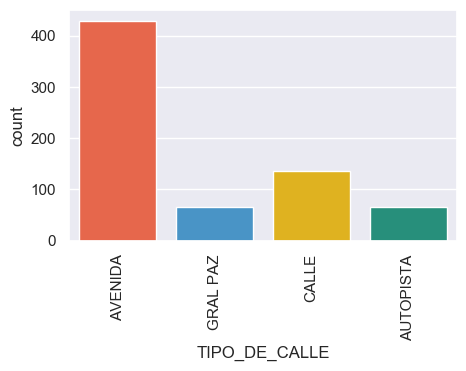

In [183]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='TIPO_DE_CALLE')
plt.xticks(rotation=90)
plt.show()

**Observaciones:** La avenida es el tipo de calle donde ocurrieron la mayor cantidad de accidentes fatales.

#### 2. COMUNA

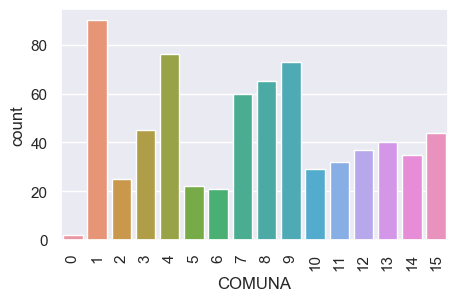

In [184]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='COMUNA')
plt.xticks(rotation=90)
plt.show()

**Observaciones:**  Los datos que aparecen en la comuna 0, corresponden a datos que tienen error en la latitud y longitud, pero tienen información valiosa en e resto de los campos por eso no se eliminaron. La comuna 1 presenta una mayor cantidad de accidentes fatales, seguido por la comuna 4, 9 8 y 7.

### 3. BARRIO

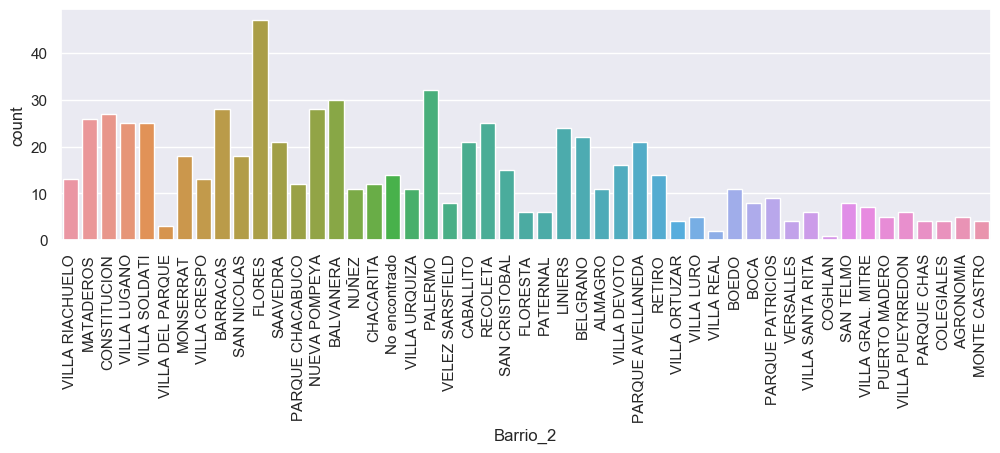

In [56]:
plt.figure(figsize=(12, 3))
sns.countplot(data=geo_hechos, x='Barrio_2')
plt.xticks(rotation=90)
plt.show()

**Observaciones**:  El agregado de la columna Barrio permite hacer un análisis zonal mas focalizado. Dentro de la comunas con mas accidentes fatales pueden identificarse los barrios. Por ejemplo en la Comuna 1 el barrio con mayor cantidad de accidentes es Flores.

### 4. PARTICIPANTES

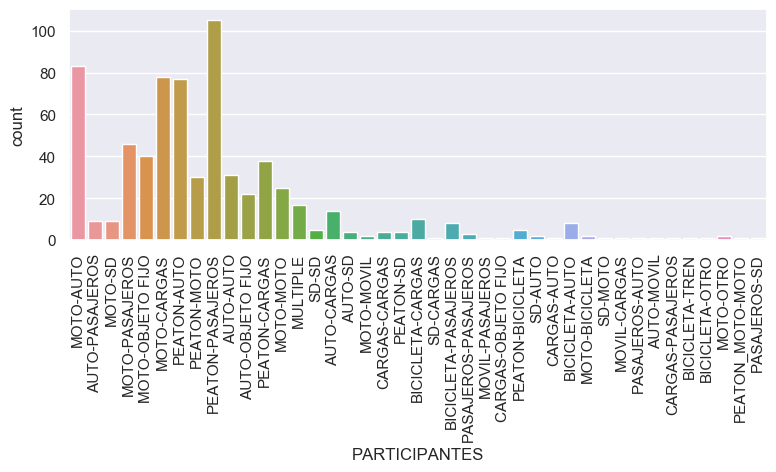

In [57]:
plt.figure(figsize=(9, 3))
sns.countplot(data=geo_hechos, x='PARTICIPANTES')
plt.xticks(rotation=90)
plt.show()

**Observaciones**: Este grafico nos permite identificar cual es la naturaleza del choque que ocurrio mas frencuentemente para las víctimas fatales. La mayor cantidad de homicidios se da para el choque entre vehiculos de transporte de pasajeros y peatones.

### 5. VICTIMA

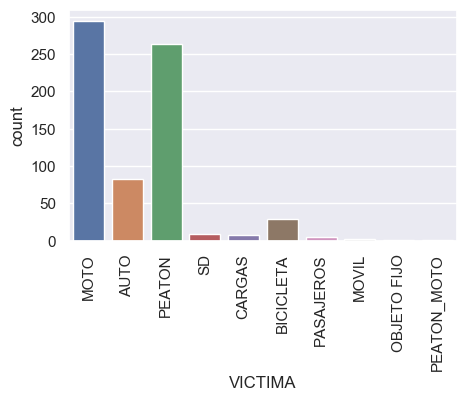

In [58]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='VICTIMA')
plt.xticks(rotation=90)
plt.show()

**Observaciones:** Este gráfico nos muestra que en los accidentes de transito fatales las principales víctimas son los motociclistas, seguido por los peatones.

### 6. ACUSADO

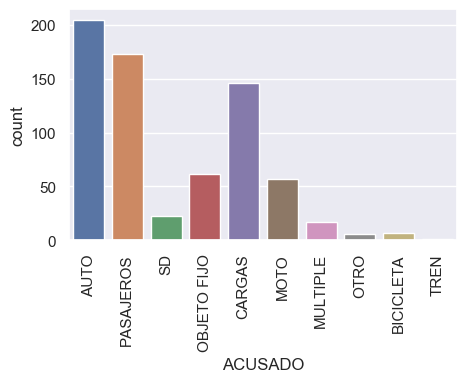

In [59]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='ACUSADO')
plt.xticks(rotation=90)
plt.show()

**Observaciones:** Este gráfico nos muestra que en los accidentes de transito fatales los principales acusado son los AUTOS,  seguidos por los los vehículos de transporte de pasajeros.

### HORA

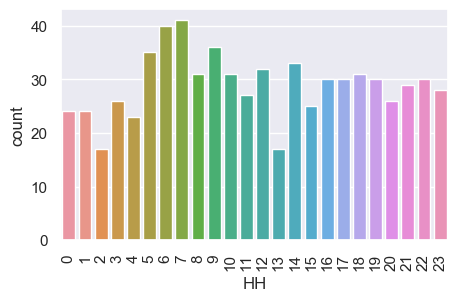

In [189]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='HH')
plt.xticks(rotation=90)
plt.show()

**Observaciones:** Este gráfico nos muestra que existe un horario entre las 6 y 7 de la mañana donde se ve un pico en la cantidad de accidentes fatales. El motivo puede estar asociado a que en ese horario hay mucho movimiento de transito y peatones debido a los traslados a los trabajos.

In [190]:
### AÑO

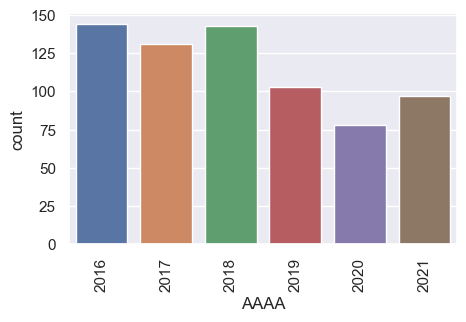

In [61]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='AAAA')
plt.xticks(rotation=90)
plt.show()

**Observaciones:** Este grafico muestra una tendecia de baja de accidentes fatales con los años.

### MES

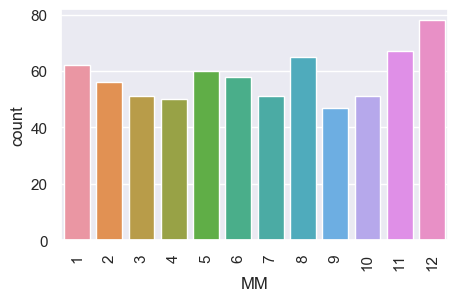

In [62]:
plt.figure(figsize=(5, 3))
sns.countplot(data=geo_hechos, x='MM')
plt.xticks(rotation=90)
plt.show()

**Observaciones:** La tendendia de ocurrencia de accidentes con los meses se observa bastante constante, pero con un máximo en el mes 12, que puede estar asociado a las fiestas de fin de año. 

### df_victimas

### ROL

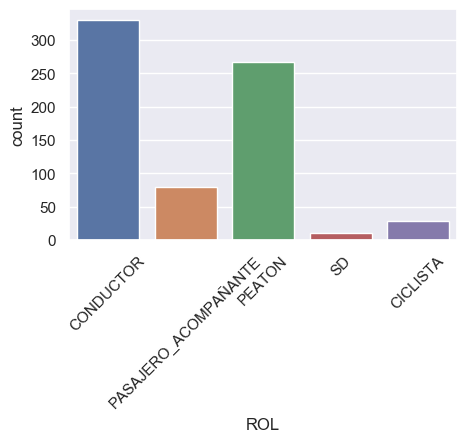

In [63]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_victimas, x='ROL')
plt.xticks(rotation=45)
plt.show()

**Observaciones:** Este grafico nos muestra el ROL de las victimas predominante es el del conductor seguido por peatón. El rol de conductor contiene todas las categorias de los homicidos de los participantes motorizados, mientras los peatones es una categoria por si misma.

### SEXO

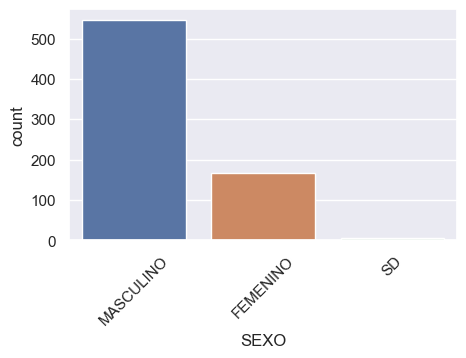

In [64]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_victimas, x='SEXO')
plt.xticks(rotation=45)
plt.show()

**Observaciones:**  Este gráfico nos muestra que el sexo masculino prevalece sobre el femenino en las vitimas fatales.

## 6. Generación de dataset final para exportar

In [202]:
df_final=pd.merge(geo_hechos,df_victimas[['ID_hecho','ROL', 'SEXO','VICTIMA',
       'EDAD', 'FECHA_FALLECIMIENTO']], left_on='ID', right_on='ID_hecho',how='inner')

In [ ]:
#df_final.to_csv('hechos_victimas.csv')